In [1]:
import secrets
import pandas as pd
import numpy as np # type: ignore
import seaborn as sns
import plotly.io as pio

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set(style="whitegrid")

In [2]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [3]:
import model.basic_model as basic_model
import model.agents as agents
from model.stochastic_processes import (
    create_stochastic_avail_price_process,
    plot_price,
)
from model.agents_class import Stake
import model.agent_rebalance as rebalance

from real_data_fetcher import fetch

In [4]:
# types
Run = int
Timestep = int

# Price Traj Generation

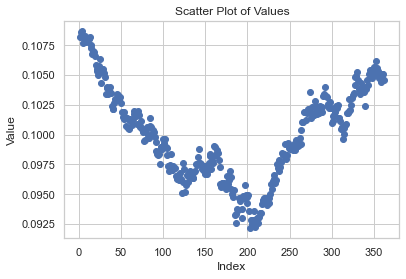

[np.float64(0.10816962298003223), np.float64(0.10824798134116179), np.float64(0.1086579897805936), np.float64(0.10872670874567886), np.float64(0.10765930457474407), np.float64(0.10812892231716678), np.float64(0.1082796535674379), np.float64(0.10774668439966835), np.float64(0.10799206262606983), np.float64(0.10808722884513103), np.float64(0.10813383612829036), np.float64(0.10799602518538387), np.float64(0.10821926447214761), np.float64(0.10755019026358992), np.float64(0.10728060881643103), np.float64(0.10678938715428651), np.float64(0.10705069652743467), np.float64(0.10692344507850089), np.float64(0.10656552989327586), np.float64(0.10586752843255938), np.float64(0.10553504772477644), np.float64(0.10538762296171267), np.float64(0.10504323224480941), np.float64(0.10579138626930386), np.float64(0.10634007352802538), np.float64(0.10430249179251788), np.float64(0.10536586771434854), np.float64(0.10533707327668383), np.float64(0.10548086966153392), np.float64(0.1051827347496254), np.float64(0

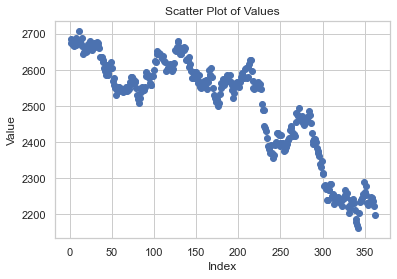

[np.float64(2675.9171335948668), np.float64(2687.6414656660827), np.float64(2674.081601237848), np.float64(2670.4738870052465), np.float64(2668.1838234140396), np.float64(2682.6124748972875), np.float64(2690.0914793931474), np.float64(2669.5532085726472), np.float64(2673.3748269904445), np.float64(2681.3792602628055), np.float64(2709.413541425137), np.float64(2682.228923181944), np.float64(2671.64810091669), np.float64(2688.227575750004), np.float64(2665.7732262580344), np.float64(2645.586644551605), np.float64(2650.335854580555), np.float64(2662.373365155212), np.float64(2649.9187888463903), np.float64(2655.026624777719), np.float64(2653.997104748052), np.float64(2673.3325602121986), np.float64(2670.5985296072317), np.float64(2682.275007243481), np.float64(2666.4638372407962), np.float64(2661.0909931512547), np.float64(2657.0066144925345), np.float64(2670.876813595188), np.float64(2676.629960608539), np.float64(2663.056864908718), np.float64(2670.312393639756), np.float64(2678.8634908

In [5]:
avl_price_samples = create_stochastic_avail_price_process(price_traj_type = 'concave',minimum_avl_price=0.05, target_avg=0.1, maximum_avl_price=1.0,)
plot_price(avl_price_samples) 
print(avl_price_samples)

eth_price_samples = create_stochastic_avail_price_process(price_traj_type = 'concave', minimum_avl_price=1500,target_avg=2500, maximum_avl_price=3000)
plot_price(eth_price_samples) 
print(eth_price_samples)

avl_price_samples = [float(x) for x in avl_price_samples]
eth_price_samples = [float(x) for x in eth_price_samples]
print(avl_price_samples)
print(eth_price_samples)

In [6]:
# avl_price_samples, eth_price_samples, Timestep = fetch(symbol_avl='hawk')

# plot_price(avl_price_samples) 
# print(avl_price_samples)

# plot_price(eth_price_samples) 
# print(eth_price_samples)

# Setup

In [7]:
constants = {
}

In [8]:
AVL_initial_price = avl_price_samples[0]
ETH_initial_price = eth_price_samples[0]
print(AVL_initial_price)

0.10816962298003223


In [9]:
ETH_upper_security_pct = [.2]
AVL_upper_security_pct = [.8]

# Simulation

In [10]:
init_agent_eth_alloc = [1, 0]
init_agent_avl_alloc = [1-i for i in init_agent_eth_alloc]
agents_composition = [ETH_upper_security_pct[0],AVL_upper_security_pct[0]] # sum = 1

In [11]:
init_AVL_price = AVL_initial_price
init_fdv = 10000000000 * init_AVL_price
init_inflation_rate = 4
init_rewards_allocation = 57.5
init_target_avg_yield = 13.8
init_total_inflation_rewards = init_fdv * init_inflation_rate /100
init_total_annual_rewards_fusion = init_total_inflation_rewards * init_rewards_allocation / 100


init_target_total_security = init_total_annual_rewards_fusion * 100 / init_target_avg_yield

print(init_target_total_security)

180282704.96672037


In [12]:
init_AVL_security_pct = [ i*j for i,j in zip(init_agent_avl_alloc, agents_composition)]
init_ETH_security_pct = [ i*j for i,j in zip(init_agent_eth_alloc, agents_composition)]

print(init_AVL_security_pct, init_ETH_security_pct)

init_total_AVL_security_pct = sum(init_AVL_security_pct)
init_total_ETH_security_pct = sum(init_ETH_security_pct)

print([i/init_total_AVL_security_pct for i in init_AVL_security_pct])
print([i/init_total_ETH_security_pct for i in init_ETH_security_pct])


agents_avl_balance = [init_target_total_security * pct / AVL_initial_price for pct in init_AVL_security_pct]
agents_eth_balance = [init_target_total_security * pct / ETH_initial_price for pct in init_ETH_security_pct]

print(agents_avl_balance)
print(agents_eth_balance)

[0.0, 0.8] [0.2, 0.0]
[0.0, 1.0]
[1.0, 0.0]
[0.0, 1333333333.3333333]
[13474.460976639133, 0.0]


In [13]:
df = pd.DataFrame({
    'Agent ETH Allocation %': init_agent_eth_alloc,
    'Agent AVL Allocation %': init_agent_avl_alloc
})
df['Agent ETH Allocation %'] = df['Agent ETH Allocation %'].apply(lambda x: f"{x:.2%}")
df['Agent AVL Allocation %'] = df['Agent AVL Allocation %'].apply(lambda x: f"{x:.2%}")
print(df)


avl_normalized = [i / sum(init_AVL_security_pct) for i in init_AVL_security_pct]
eth_normalized = [i / sum(init_ETH_security_pct) for i in init_ETH_security_pct]

df = pd.DataFrame({
    'AVL Security %': avl_normalized,
    'ETH Security %': eth_normalized
})
df['AVL Security %'] = df['AVL Security %'].apply(lambda x: f"{x:.2%}")
df['ETH Security %'] = df['ETH Security %'].apply(lambda x: f"{x:.2%}")
print(df)


df = pd.DataFrame({
    'User Total Proportion': agents_composition
})
df['User Total Proportion'] = df['User Total Proportion'].apply(lambda x: f"{x:.2%}")
print(df)


df = pd.DataFrame({
    'Total Security %': [init_total_AVL_security_pct*100, init_total_ETH_security_pct*100]
}, index=['AVL', 'ETH'])
df['Total Security %'] = df['Total Security %'].apply(lambda x: f"{x:.0f}%")
print(df)

  Agent ETH Allocation % Agent AVL Allocation %
0                100.00%                  0.00%
1                  0.00%                100.00%
  AVL Security % ETH Security %
0          0.00%        100.00%
1        100.00%          0.00%
  User Total Proportion
0                20.00%
1                80.00%
    Total Security %
AVL              80%
ETH              20%


In [14]:
@dataclass
class FusionParams:
    # TODO: Set a AVL amount budget cap
    AVL_upper_budget_cap = 1.12e8
    ETH_upper_budget_cap = 2.08e8


    avl_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: avl_price_samples[timestep]]
    )
    eth_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: eth_price_samples[timestep]]
    )

    # inlation % on AVL
    inflation_rate: List[float] = default([init_inflation_rate])


    # Reward Allocation to Pools
    ETH_reward_pct: List[float] = default([90])
    AVL_reward_pct: List[float] = default([10])


    # % of Fusion Security Standard met by ETH Stake
    # TODO: implementation
    ETH_upper_security_pct: List[float] = field(default_factory=lambda: ETH_upper_security_pct)
    AVL_upper_security_pct: List[float] = field(default_factory=lambda: AVL_upper_security_pct)



    # Agents
    ETH_agent_allocation: List[List[float]] = default([
        init_agent_eth_alloc
    ])
    AVL_agent_allocation: List[List[float]] = default([
        init_agent_avl_alloc
    ])
    # Agents_composition: List[List[float]] = default([
    #     agents_composition
    # ])

    # agents_avl_balance: List[List[float]] = default([
    #     agents_avl_balance
    # ])

    # agents_eth_balance: List[List[float]] = default([
    #     agents_eth_balance
    # ])

    # Inflation Policy
    inflation_decay: List[float] = default([0.05])
    target_staking_rate: List[float] = default([0.5])
    min_inflation_rate: List[float] = default([0.01])
    max_inflation_rate: List[float] = default([0.05])

    # Utility Functions
    c_avl: List[float] = default([1])
    c_eth: List[float] = default([1])
    avl_yield_equilibrium: List[float] = default([0.15])
    eth_yield_equilibrium: List[float] = default([0.3])

parameters = FusionParams().__dict__

In [15]:
def update_initial_state(simulation, eth_security_pct, avl_security_pct, avl_price, eth_price):
    # Update the security percentage for ETH and AVL
    agents_composition = [eth_security_pct[0], avl_security_pct[0]]
    init_agent_eth_alloc = [1, 0]
    init_agent_avl_alloc = [1 - i for i in init_agent_eth_alloc]
    
    # Initial conditions
    init_fdv = 10000000000 * avl_price
    init_inflation_rate = 4 
    init_rewards_allocation = 20
    init_target_avg_yield = 10
    init_total_inflation_rewards = init_fdv * init_inflation_rate / 100
    init_total_annual_rewards_fusion = init_total_inflation_rewards * init_rewards_allocation / 100
    init_target_total_security = init_total_annual_rewards_fusion * 100 / init_target_avg_yield
    
    # Calculate security percentages
    init_AVL_security_pct = [i * j for i, j in zip(init_agent_avl_alloc, agents_composition)]
    init_ETH_security_pct = [i * j for i, j in zip(init_agent_eth_alloc, agents_composition)]
    
    # Compute balances based on updated percentages
    agents_avl_balance = [init_target_total_security * pct / avl_price for pct in init_AVL_security_pct]
    agents_eth_balance = [init_target_total_security * pct / eth_price for pct in init_ETH_security_pct]
    
    # Update the initial state in the simulation model
    simulation.model.initial_state.update({
        "timestep": 0,
        "avl_price": avl_price,
        "eth_price": eth_price, 
        "AVL_security_pct": sum(init_AVL_security_pct) * 100,
        "ETH_security_pct": sum(init_ETH_security_pct) * 100,
        "total_security": init_target_total_security,
        "total_fdv": init_fdv,
        "total_annual_rewards": init_total_inflation_rewards,
        "total_annual_rewards_fusion": init_total_annual_rewards_fusion,
        "avg_yield": init_target_avg_yield,
        "ETH_stake": Stake(eth_price, agents_eth_balance, 0, 0),
        "AVL_stake": Stake(avl_price, agents_avl_balance, 0, 0),
        "yield_pcts": [0, 0],
        "avg_yield": 0.0,
    })
    
    # Return updated security percentages and balances for confirmation
    return init_AVL_security_pct, init_ETH_security_pct, agents_avl_balance, agents_eth_balance


In [16]:
psub = [
    {
        "policies": {
             },
        "variables": {
            "timestep": basic_model.update_timestep,
            "avl_price": basic_model.update_avl_price,
            "eth_price": basic_model.update_eth_price,
        }
    }, {
        "policies": {
            "action":rebalance.policy_agent_rebalance
             },
        "variables": {
            "ETH_stake": rebalance.update_ETH_stake,
            "AVL_stake": rebalance.update_AVL_stake,
        }
    }, 
    {
        "policies": {
            "action":basic_model.policy_tune_rewards_allocation
             },
        "variables": {
            "rewards_allocation": basic_model.update_rewards_allocation,
        }
    }, 
    {
        "policies": {
            "action":basic_model.calc_rewards
             },
        "variables": {
            "total_annual_rewards": basic_model.update_total_annual_rewards,
            "total_annual_rewards_fusion": basic_model.update_total_annual_rewards_fusion,
            "total_fdv": basic_model.update_total_fdv,
            "inflation_rate": basic_model.update_inflation_rate,
        }
    }, 
    {
        "policies": {
            "action": basic_model.calc_security_shares
            },
            "variables": {
                "AVL_security_pct": basic_model.update_AVL_pct,
                "ETH_security_pct": basic_model.update_ETH_pct,
                "total_security": basic_model.update_total_security,
                "ETH_stake": basic_model.update_ETH_stake,
                "AVL_stake": basic_model.update_AVL_stake,
                "staking_ratio": basic_model.update_staking_ratio,  
            }
    },
    {
        "policies": {
            "action": basic_model.calc_agents_balances
            },
            "variables": {
                "ETH_stake": basic_model.update_ETH_stake,
                "AVL_stake": basic_model.update_AVL_stake,
            }
    },
    {
        "policies": {
            "action": agents.calc_rewards_allocation
            },
            "variables": {
                "AVL_stake": agents.update_AVL_stake,
                "ETH_stake": agents.update_ETH_stake,
            }
    },
    {
        "policies": {
            "action": agents.calc_yields
            },
            "variables": {
                "yield_pcts": agents.update_yields,
                "avg_yield": agents.update_avg_yield,
            }
    },
]

initial_conditions = {
    "timestep": 0,
    "avl_price": AVL_initial_price,
    "eth_price": ETH_initial_price, 
    "AVL_security_pct": sum(init_AVL_security_pct) * 100,
    "ETH_security_pct": sum(init_ETH_security_pct) * 100,
    "total_security": init_target_total_security,
    # "target_total_security": init_target_total_security,
    "total_fdv": init_fdv,
    "staking_ratio": 0.0,
    "total_annual_rewards": 0,
    "total_annual_rewards_fusion": init_total_annual_rewards_fusion,
    "avg_yield": 5.0,
    "inflation_rate": 0.01,
    "ETH_stake": Stake(ETH_initial_price, agents_eth_balance,0,0),
    "AVL_stake": Stake(AVL_initial_price, agents_avl_balance,0,0),
    "yield_pcts": [0,0],
    "avg_yield": 0.0,
    "rewards_allocation": init_rewards_allocation,
}


params = parameters



In [17]:
model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=params
)

simulation=Simulation(model=model, timesteps=300, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
results  = experiment.run()
df= pd.DataFrame(results)


In [18]:
df

,timestep,avl_price,eth_price,AVL_security_pct,ETH_security_pct,total_security,total_fdv,staking_ratio,total_annual_rewards,total_annual_rewards_fusion,avg_yield,inflation_rate,ETH_stake,AVL_stake,yield_pcts,rewards_allocation,simulation,subset,run,substep
0,0,0.108170,2675.917134,80.000000,20.000000,1.802827e+08,1.081696e+09,0.000000,0.000000e+00,2.487901e+07,0.000000,0.010000,"Stake(initial_price=2675.9171335948668, agents...","Stake(initial_price=0.10816962298003223, agent...","[0, 0]",57.5,0,0,1,0
1,1,0.108170,2675.917134,80.000000,20.000000,1.802827e+08,1.081696e+09,0.000000,0.000000e+00,2.487901e+07,0.000000,0.010000,"Stake(initial_price=2675.9171335948668, agents...","Stake(initial_price=0.10816962298003223, agent...","[0, 0]",57.5,0,0,1,1
2,1,0.108170,2675.917134,80.000000,20.000000,1.802827e+08,1.081696e+09,0.000000,0.000000e+00,2.487901e+07,0.000000,0.010000,"Stake(initial_price=2675.9171335948668, agents...","Stake(initial_price=0.10816962298003223, agent...","[0, 0]",57.5,0,0,1,2
3,1,0.108170,2675.917134,80.000000,20.000000,1.802827e+08,1.081696e+09,0.000000,0.000000e+00,2.487901e+07,0.000000,0.010000,"Stake(initial_price=2675.9171335948668, agents...","Stake(initial_price=0.10816962298003223, agent...","[0, 0]",57.5,0,0,1,3
4,1,0.108170,2675.917134,80.000000,20.000000,1.802827e+08,1.081696e+09,0.000000,1.081696e+07,6.219753e+06,0.000000,0.010000,"Stake(initial_price=2675.9171335948668, agents...","Stake(initial_price=0.10816962298003223, agent...","[0, 0]",57.5,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,300,0.100973,2314.840262,78.445778,21.554222,1.737803e+08,1.009727e+09,0.169969,2.382703e+07,1.370054e+07,7.970858,0.023598,"Stake(initial_price=2346.9194075855667, agents...","Stake(initial_price=0.10224250049961019, agent...","[33.282447627350635, 1.0160978111477792]",57.5,0,0,1,4
2397,300,0.100973,2314.840262,78.448969,21.551031,1.716151e+08,1.009727e+09,0.169962,2.382703e+07,1.370054e+07,7.970858,0.023598,"Stake(initial_price=2314.840262130446, agents_...","Stake(initial_price=0.10097269706062059, agent...","[33.282447627350635, 1.0160978111477792]",57.5,0,0,1,5
2398,300,0.100973,2314.840262,78.448969,21.551031,1.716151e+08,1.009727e+09,0.169962,2.382703e+07,1.370054e+07,7.970858,0.023598,"Stake(initial_price=2314.840262130446, agents_...","Stake(initial_price=0.10097269706062059, agent...","[33.282447627350635, 1.0160978111477792]",57.5,0,0,1,6
2399,300,0.100973,2314.840262,78.448969,21.551031,1.716151e+08,1.009727e+09,0.169962,2.382703e+07,1.370054e+07,7.970858,0.023598,"Stake(initial_price=2314.840262130446, agents_...","Stake(initial_price=0.10097269706062059, agent...","[33.282447627350635, 1.0160978111477792]",57.5,0,0,1,7


In [19]:
visualizations.plot_token_price_per_subset(
    df,
    scenario_names={
        0: "downside",
    }
)

In [20]:

fig= visualizations.plot_security_pct(
    df
)
pio.show(fig)


In [21]:
fig = visualizations.plot_avg_overall_yield(
    df
)
pio.show(fig)


In [22]:
fig = visualizations.plot_yield_pct(
    df, init_agent_eth_alloc
)
pio.show(fig)

In [23]:
fig= visualizations.plot_staking_ratio_inflation_rate(
    df
)
pio.show(fig)